# Calculate Dislocation

In [1]:
import geopandas as gpd

vtds = gpd.read_file("../00_source_data/alarmshape 2021-10-07.shp")


In [2]:
vtds.columns

Index(['ID', 'STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'VTDI20',
       'NAME20', 'NAMELSAD20', 'LSAD20', 'MTFCC20', 'FUNCSTAT20', 'ALAND20',
       'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'OID_', 'GEOID20_1', 'RVPRE20',
       'DVPRE20', 'TPTYPRE20', 'RVPRES16', 'DVPRES16', 'TPTYPR16', 'RVUSS16',
       'DVUSS16', 'TPTYUSS16', 'STATEFP', 'COUNTYFP', 'DISTRICT', 'G18USSRREN',
       'G18USSDBRO', 'G18GOVRDEW', 'G18GOVDCOR', 'G18GOVLIRV', 'G18GOVGGAD',
       'G18ATGRYOS', 'G18ATGDDET', 'G18AUDRFAB', 'G18AUDDSPA', 'G18AUDLCOO',
       'G18SOSRLAR', 'G18SOSDCLY', 'G18SOSLNAN', 'G18TRERSPR', 'G18TREDRIC',
       'RVUSS18', 'DVUSS18', 'TPTYUSS18', 'RVGOV18', 'DVGOV18', 'TPTYGOV18',
       'RVATG18', 'DVATG18', 'TPTYATG18', 'RVAUD18', 'DVAUD18', 'TPTYAUD18',
       'RVSOS18', 'DVSOS18', 'TPTYSOS18', 'RVTRE18', 'DVTRE18', 'TPTYTRE18',
       'geometry'],
      dtype='object')

## Calc vote shares


In [3]:
elections = ["PRE20", "PRES16", "USS16", "USS18", "GOV18", "ATG18", "AUD18", "SOS18", "TRE18"]

for p in ["D", "R"]:
    vtds[f"{p}_count"] = 0
    for e in elections:
        vtds[f"{p}_count"] += vtds[p+"V"+e]
    vtds[f"{p}_count"] = vtds[f"{p}_count"] / len(elections)

## Sanity Checks

<AxesSubplot:>

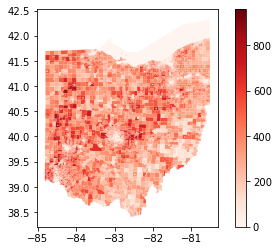

In [4]:
vtds.plot("R_count", cmap="Reds", legend=True)

<AxesSubplot:>

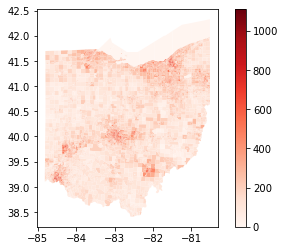

In [5]:
vtds.plot("D_count", cmap="Reds", legend=True)

In [6]:
vtds["D_count"].sum() / (vtds["D_count"].sum() + vtds["R_count"].sum())

0.46786351183282615

In [7]:
(vtds["D_count"].sum() + vtds["R_count"].sum())

4669177.466499511

## Create Representative Voters

In [8]:
import partisan_dislocation as pdn
vtds = vtds.to_crs(epsg=26917)
voters = pdn.random_points_in_polygon(
    vtds, p=0.01, dem_vote_count="D_count", repub_vote_count="R_count"
)

/Users/Nick/opt/miniconda3/envs/geo/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)


In [9]:
len(voters)

46814

<AxesSubplot:>

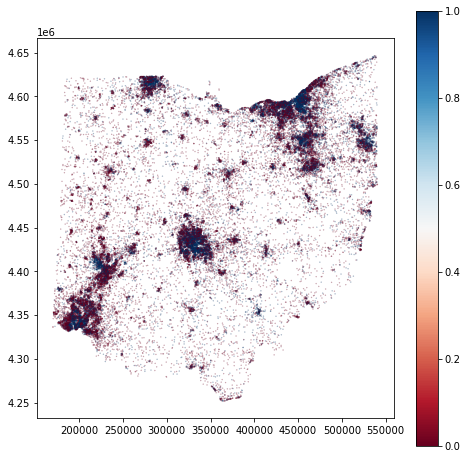

In [10]:
voters.plot("dem", cmap="RdBu", markersize=0.1, alpha=0.5, figsize=(8, 8), legend=True)


## Now KNN. 

In [11]:
knn = pdn.calculate_voter_knn(voters, k=len(voters)/99, target_column='dem')

## Dislocation


In [12]:
districts = {}
authors = ["citizens", "huffman", "sykes"]
files = {"citizens":"citizenshouse", "huffman":"huffman915houseDistricts 2021-09-29", "sykes":"sykes915house"}

for a in authors:
    districts[a] = gpd.read_file(f"../00_source_data/{files[a]}.shp")
    districts[a] = districts[a].to_crs(epsg=26917)

In [13]:
import numpy as np

dislocation_points = {}
dislocation_dists = {}
for a in authors:
    df = pdn.calculate_dislocation(
        knn, districts[a], knn_column="knn_shr_dem", dem_column="dem"
    )
    df.loc[:, "abs_partisan_dislocation"] = np.abs(df["partisan_dislocation"])
    df_points = gpd.sjoin(df, districts[a][["DISTRICT", "geometry"]])
    dislocation_points[a] = df_points


/Users/Nick/opt/miniconda3/envs/geo/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/var/folders/tj/s8f2_ks15h315z5thvtnhz8r0000gp/T/ipykernel_54445/3238088447.py:10: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +proj=utm +zone=17 +datum=NAD83 +units=m +no_defs  ...
Right CRS: EPSG:26917

  df_points = gpd.sjoin(df, districts[a][["DISTRICT", "geometry"]])
/Users/Nick/opt/miniconda3/envs/geo/lib/python3.9/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj

Avg absolute dislocation over all voters 
 for citizens is 0.0566
Most dislocated district for citizens has avg dislocation of 0.167
Avg absolute dislocation over all voters 
 for huffman is 0.0544
Most dislocated district for huffman has avg dislocation of 0.144
Avg absolute dislocation over all voters 
 for sykes is 0.0579
Most dislocated district for sykes has avg dislocation of 0.163


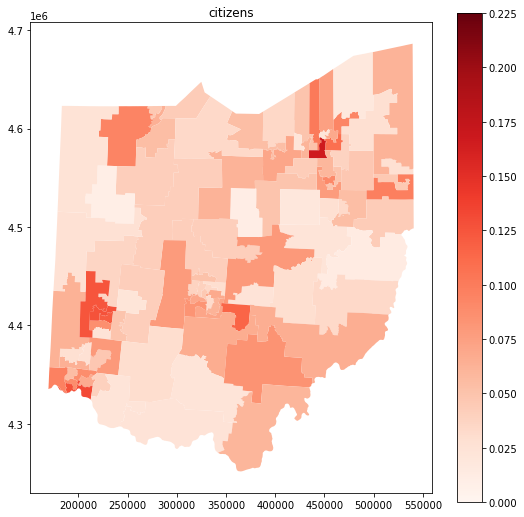

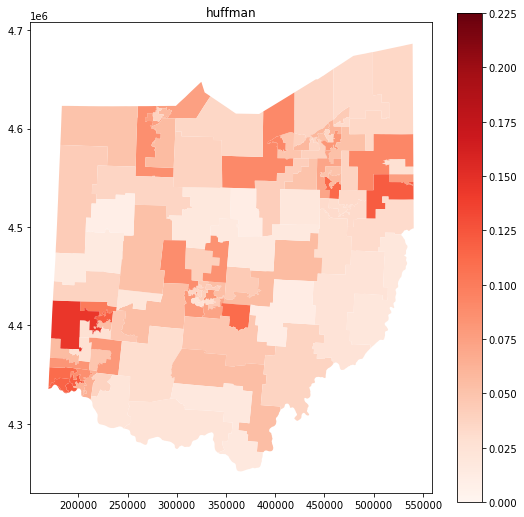

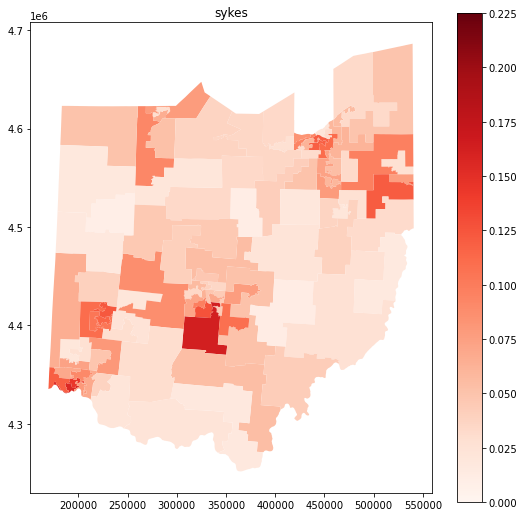

In [16]:
import pandas as pd
for a in authors:
    df = dislocation_points[a]
    print(f"Avg absolute dislocation over all voters \n for {a} is {df.abs_partisan_dislocation.mean():0.4f}")
    
    dist_scores = df.groupby("DISTRICT", as_index=False)[["abs_partisan_dislocation"]].mean()
    dist = pd.merge(districts[a], dist_scores,on="DISTRICT", how="outer", validate="1:1", indicator=True)
    dist._merge.value_counts()
    assert dist._merge.value_counts().loc["both"] == 99
    
    print(f"Most dislocated district for {a} has avg dislocation of {dist.abs_partisan_dislocation.max():0.3f}")
    
    fig = dist.plot("abs_partisan_dislocation", cmap="Reds", legend=True, figsize=(9,9), vmin=0, vmax=0.225)
    fig.set_title(a)  
    fig.figure.savefig(f"../30_results/{a}_map.png")